# 各チームごと

In [1]:
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from scipy import stats

%matplotlib inline
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook as tq

In [2]:
DATA_DIR = "../game_num_data/"

In [3]:
def filename_to_datetime(filename):
    year = filename[:4]
    month = filename[4:6]
    day = filename[6:8]
    return pd.to_datetime(year+month+day)

In [4]:
def make_df(start, end):
    case_index = 0
    inning_index = 1
    offense_team_index = 6
    defense_team_index = 2
    event_list = []
    file_list = os.listdir(DATA_DIR)[1:]
    
    date_series = pd.Series(file_list).apply(filename_to_datetime)
    target_file_list = list(pd.Series(file_list)[(date_series<pd.to_datetime(end)+pd.offsets.timedelta(1)) & (date_series>=pd.to_datetime(start))])
    
    columns = pd.read_csv(DATA_DIR+file_list[0], encoding="cp932", index_col=0, dtype="object").columns
    length = len(columns)
    
    for file in tq(target_file_list):
        curr_event_list = pd.read_csv(DATA_DIR+file, encoding="cp932", index_col=0, dtype="object").values.tolist()
        new_event_list = []
        for i in range(len(curr_event_list)):
            new_event_list.append(curr_event_list[i])
            if i < len(curr_event_list)-1 and curr_event_list[i][case_index][0] == "2" and curr_event_list[i+1][case_index][0] == "1":
                new_event_list.append(["3000", curr_event_list[i][inning_index]]+[np.nan for _ in range(length-2)])
                new_event_list.append(["0000", curr_event_list[i+1][inning_index]]+[np.nan for _ in range(length-2)])
        event_list.extend(new_event_list+[["GAMESET"]+[np.nan for _ in range(length-1)]])
        
    for i in range(len(event_list)):
        #print(event_list[i][inning_index])
        if event_list[i][inning_index] is np.nan:
            if event_list[i][case_index] != "GAMESET":
                event_list[i][inning_index] = event_list[i-1][inning_index]
                event_list[i][offense_team_index] = event_list[i-1][offense_team_index]
                event_list[i][defense_team_index] = event_list[i-1][defense_team_index]
                
    return pd.DataFrame(event_list, columns=columns)

In [5]:
def make_inning_list(event_df):
    case_index = 0
    inning_index = 1
    
    inning_list = []
    for inning in range(10):
        curr_inning_list = []
        for i in range(len(event_df)):
            if event_df.iloc[i, case_index] == "GAMESET":
                continue
            if int(event_df.iloc[i, inning_index].split("回")[0]) == inning + 1:
                curr_inning_list.append(event_df.iloc[i, case_index])
        inning_list.append(curr_inning_list)
    return inning_list

In [6]:
def make_inning_triple(inning_list):
    inning_triple_list = []
    for inning in range(len(inning_list)):
        curr_triple = []
        for i in range(2, len(inning_list[inning])):
            before, curr, after = inning_list[inning][i-2], inning_list[inning][i-1], inning_list[inning][i]
            if "GAMESET" in [before, curr, after]:
                continue
            if before == "3000" or curr == "3000":
                continue
            curr_triple.append((before, curr, after))
        inning_triple_list.append(curr_triple)
    return inning_triple_list

In [7]:
def make_flattened_list(nested_list):
    flattened_list = []
    for elem_list in nested_list:
        flattened_list += elem_list
    return flattened_list

In [8]:
def to_index(lst, dictionary):
    return [dictionary[elem] for elem in lst]

In [9]:
def ks_test(event_df, kind, title=""):
    """
    kind : "statistic" or "pvalue"
    """
    inning_list = make_inning_list(event_df)
    triple_list = make_inning_triple(inning_list)
    
    triple_set = set(make_flattened_list(triple_list))
    
    # 状況とインデックスの対応dict
    triple_dict = dict()
    for i, triple in enumerate(triple_set):
        triple_dict[triple] = i

    inning_triple_index_list = []
    for lst in triple_list:
        inning_triple_index_list.append(to_index(lst, triple_dict))
    
    # KS検定の結果
    df_ks = pd.DataFrame(index=[_ for _ in range(1, 10)], columns=[_ for _ in range(1, 10)]).astype(float)
    for i in range(9):
        for j in range(9):
            if kind == "statistic":
                df_ks.iloc[i, j] = stats.ks_2samp(inning_triple_index_list[i], inning_triple_index_list[j]).statistic
            elif kind == "pvalue":
                df_ks.iloc[i, j] = stats.ks_2samp(inning_triple_index_list[i], inning_triple_index_list[j]).pvalue
    
    plt.figure(figsize=(10, 5))
    sns.heatmap(df_ks, cmap="Blues", annot=True)
    plt.xlabel("イニング")
    plt.ylabel("イニング")
    plt.title(title+" "+str(df_ks.sum().sum()))
    plt.show()

In [10]:
event_df = make_df("20180101", "20181231")

In [11]:
central = [
    "巨人",
    "阪神",
    "広島",
    "中日",
    "ヤクルト",
    "ＤｅＮＡ",
]

pacific = [
    "ソフトバンク",
    "西武",
    "ロッテ",
    "日本ハム",
    "楽天",
    "オリックス",
]

In [12]:
event_df = make_df("20180101", "20181231")

# 各チームごとにイニング間のtripleの分布の"距離"を示す
# 各マスの中の数字が低いほど似ている
# tripleは("1100", "2010", "3000") (1out1base→2out2base→3out)みたいなやつ
# チーム名の隣にあるのは表の数字の合計

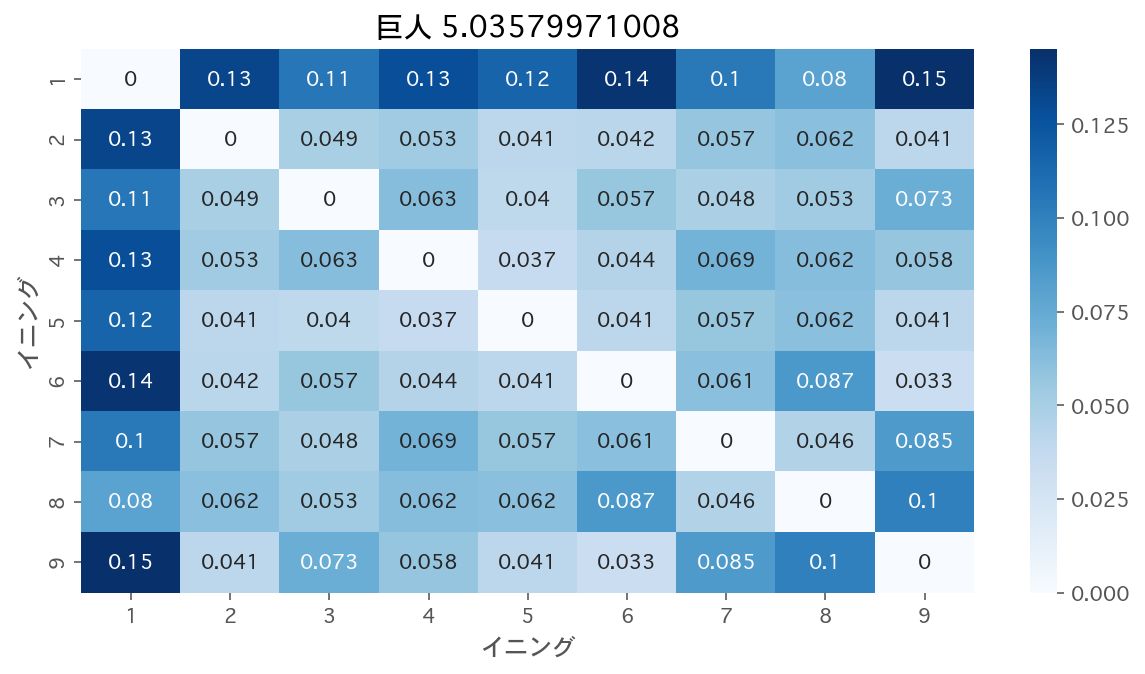

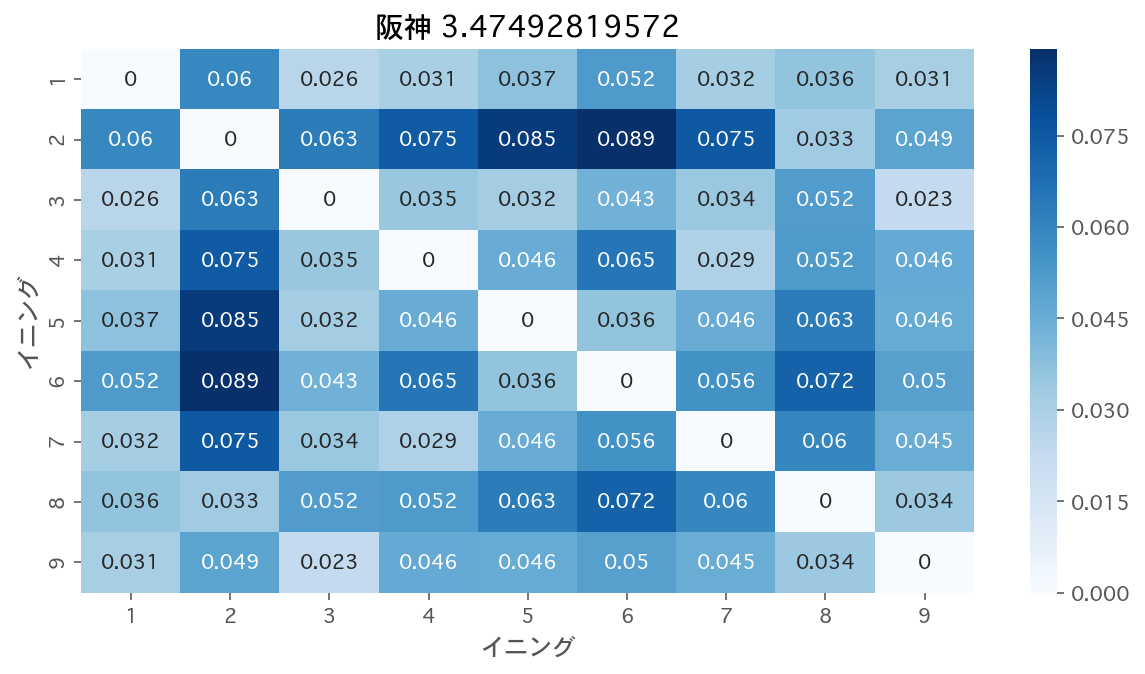

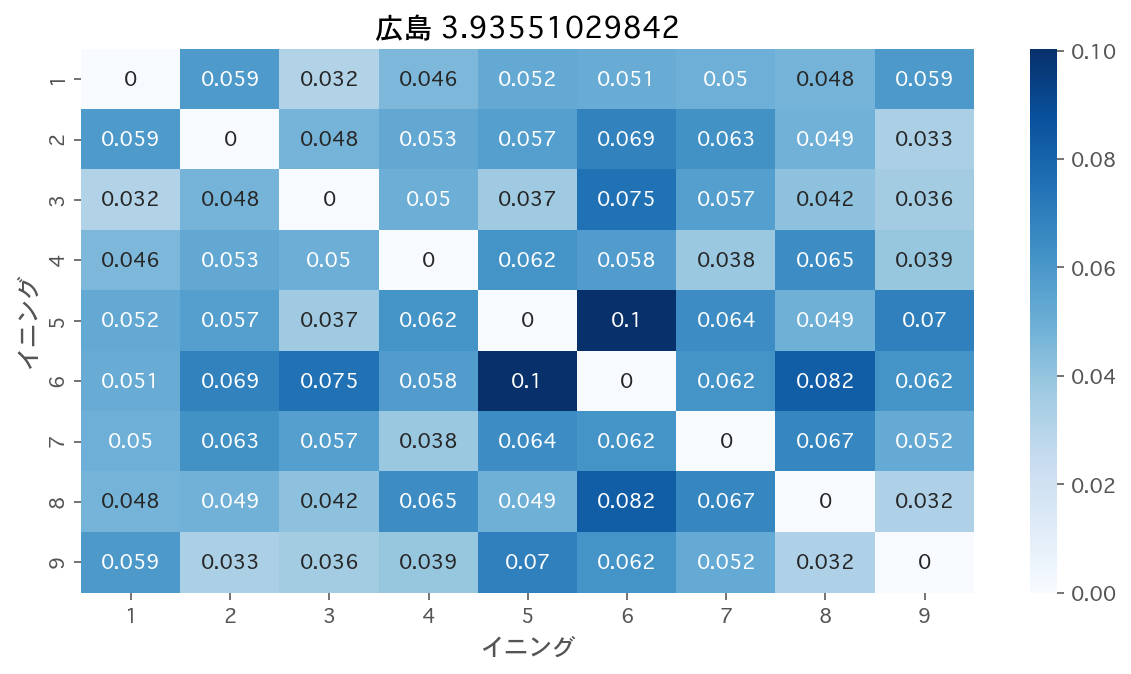

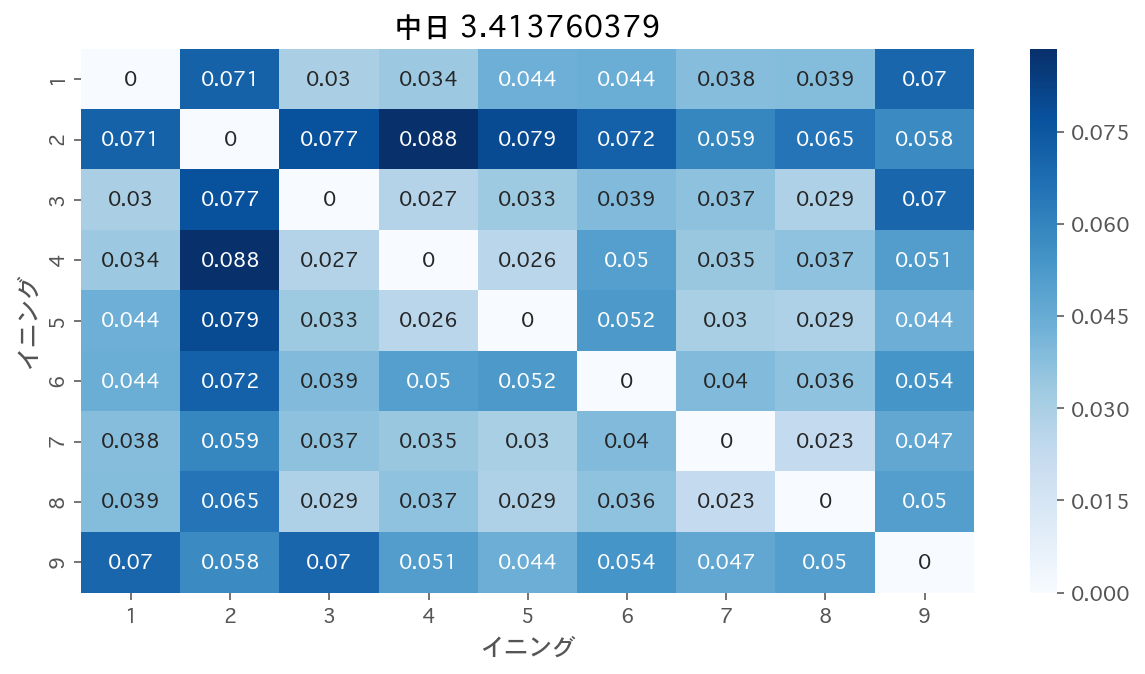

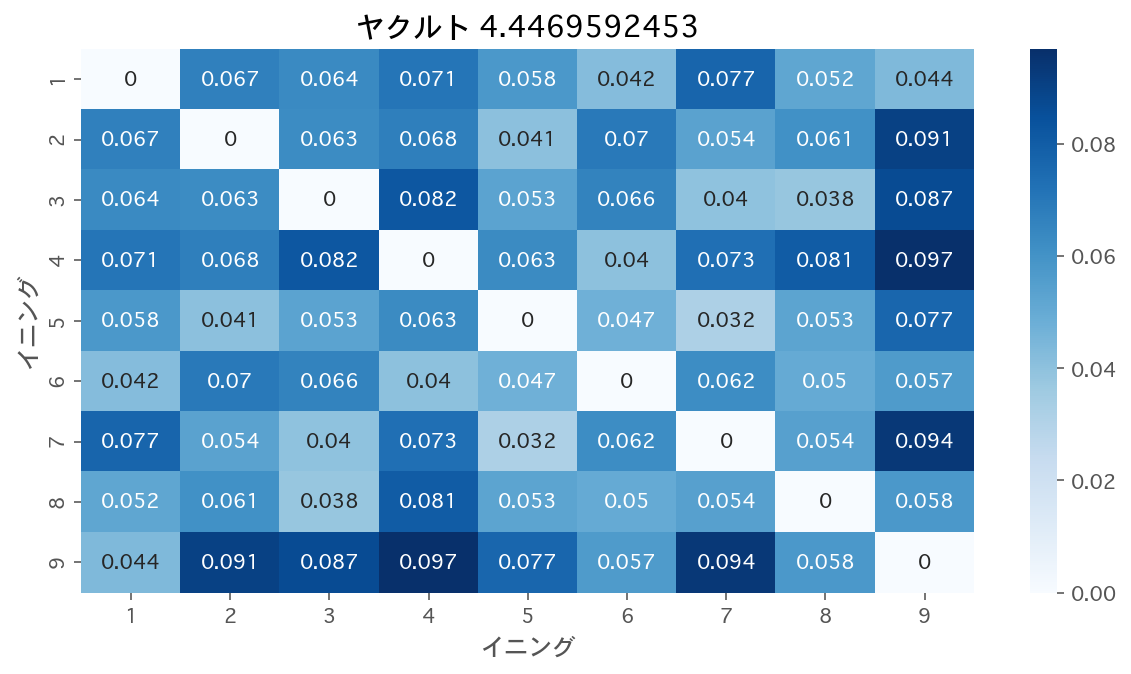

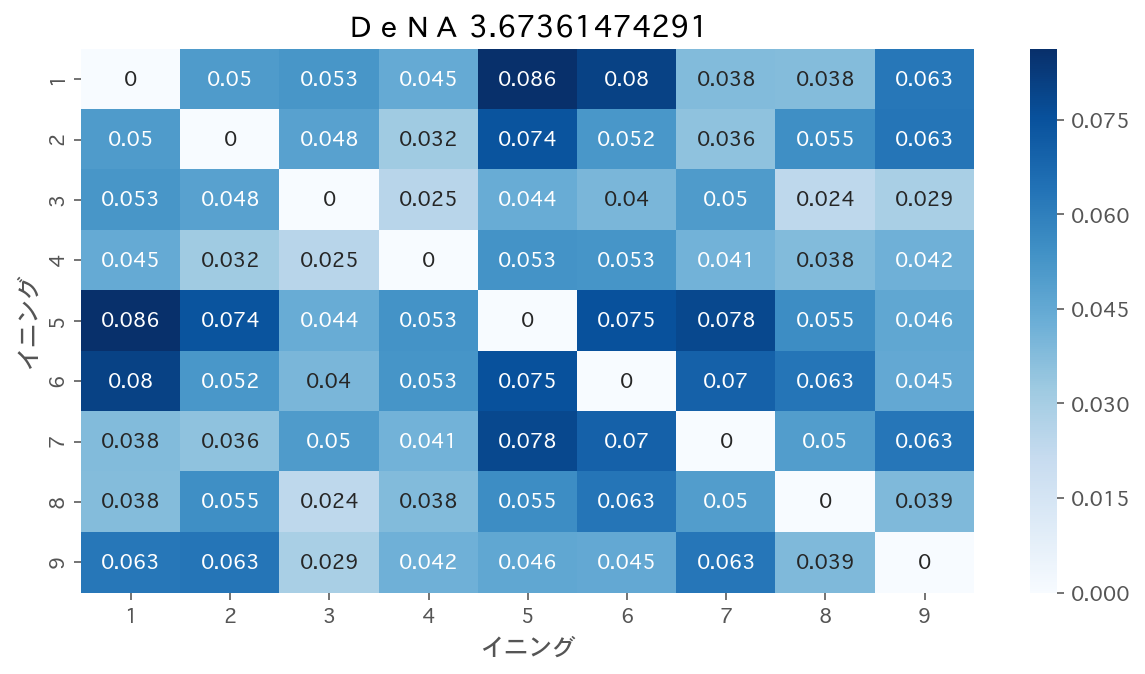

In [13]:
for team in central:
    team_event_df = event_df[event_df.攻撃チーム==team]
    ks_test(team_event_df, "statistic", title=team)

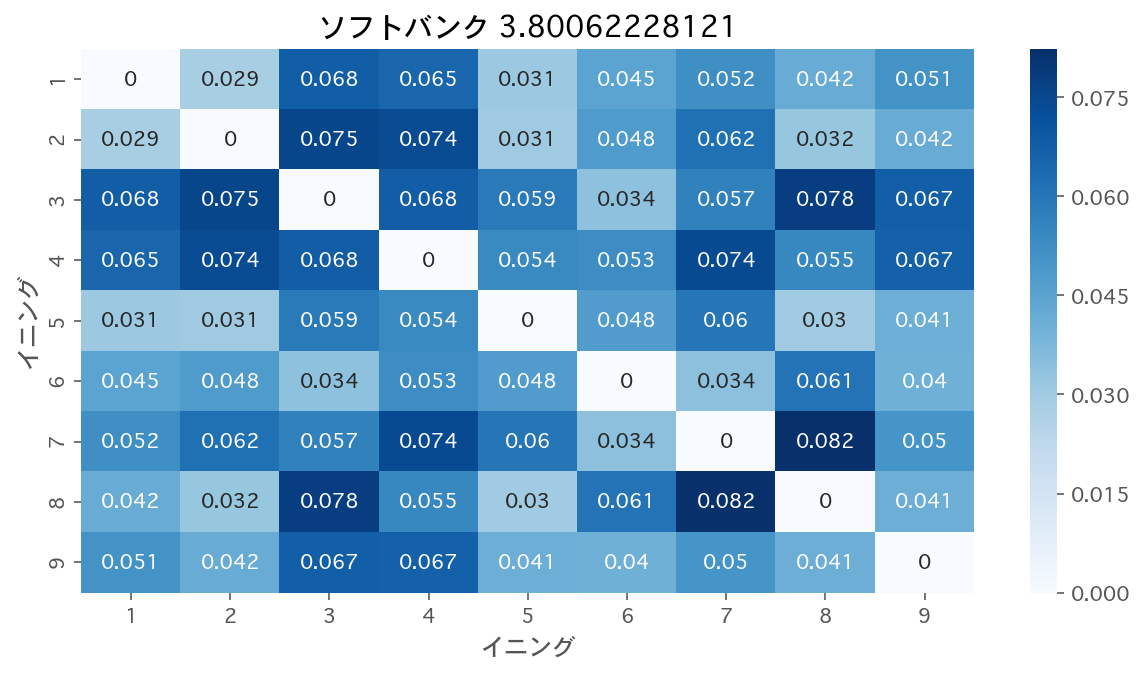

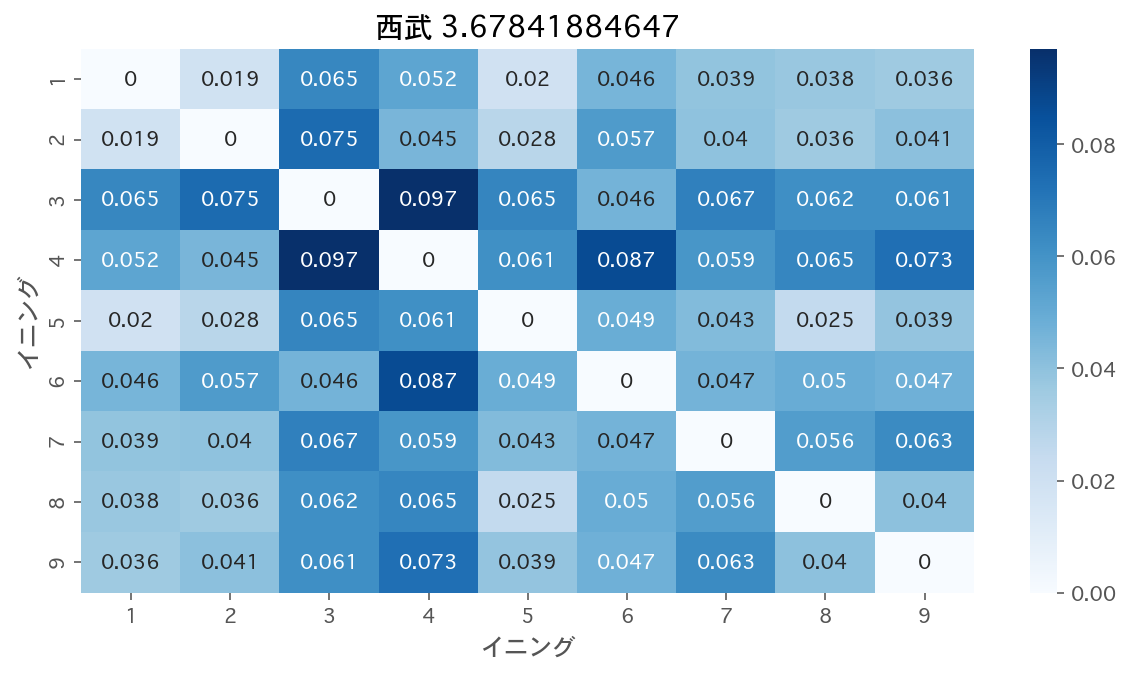

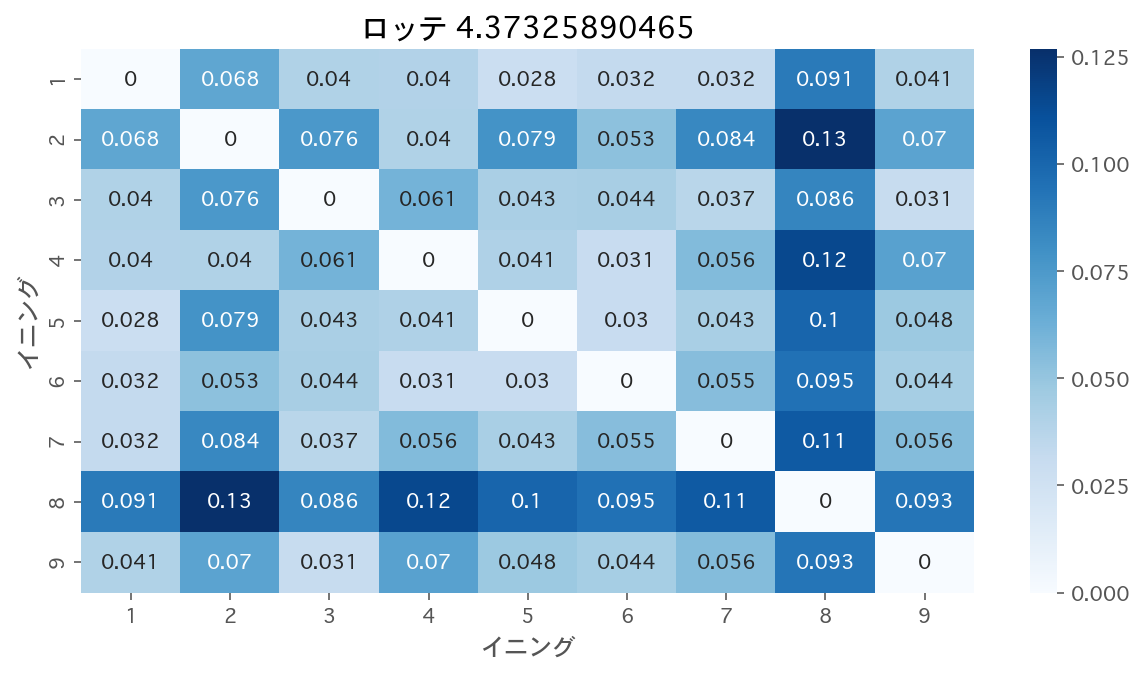

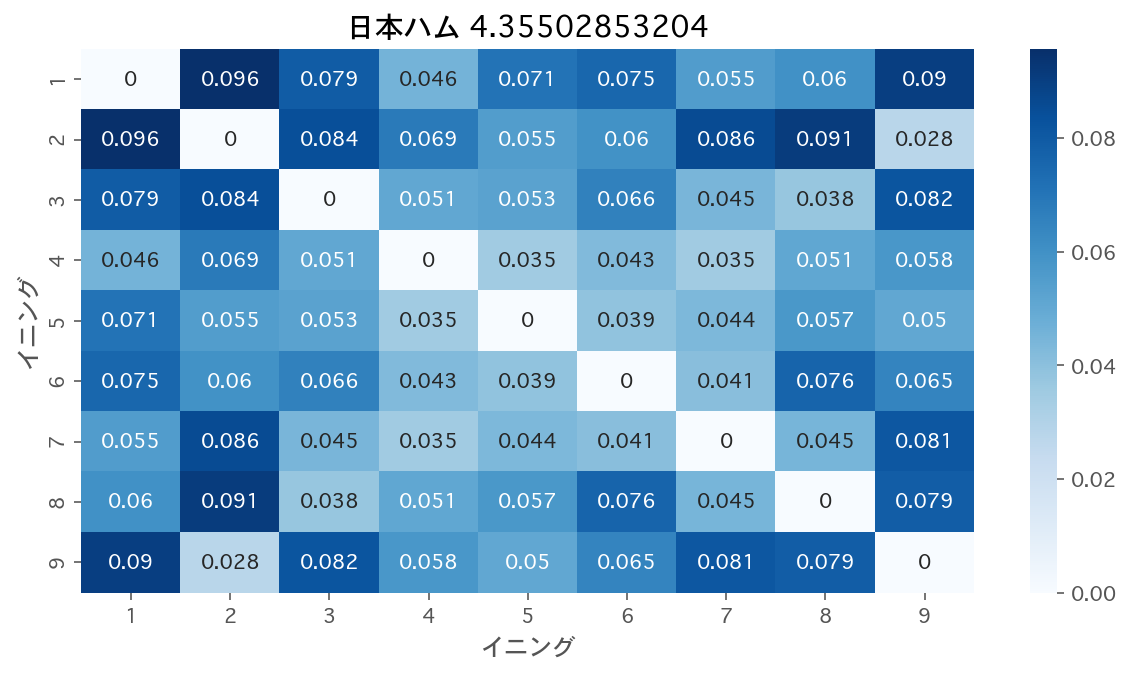

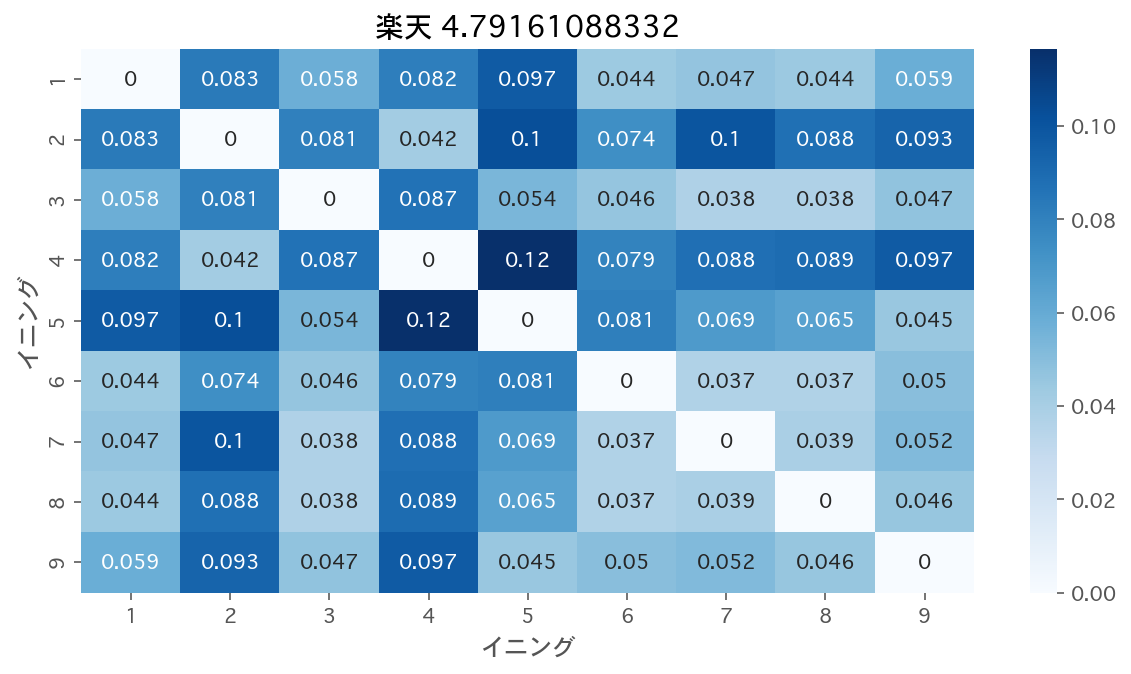

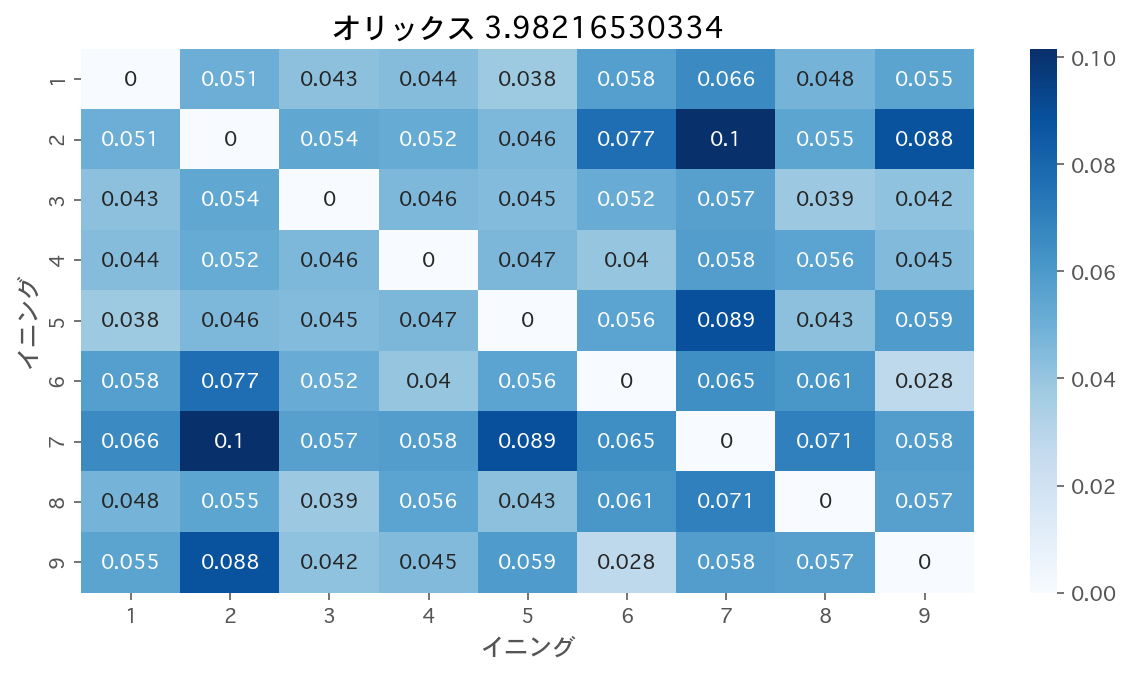

In [14]:
for team in pacific:
    team_event_df = event_df[event_df.攻撃チーム==team]
    ks_test(team_event_df, "statistic", title=team)